In [1]:
import os
from os import environ as ENV
ENV['CUDA_VISIBLE_DEVICES'] = '1'
ROOT = ENV['PWD']

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import scipy
from scipy.special import expit as sigmoid

# import jax
# import jax.numpy as jnp

import numpy as np
import numpy.typing as npt

Float = np.float64

# print(jax.devices())
# jax.config.update("jax_enable_x64", True)

# import pennylane as qml
# dev_gpu = qml.device("lightning.qubit", wires=18)  # GPU not that much slower, helps with indexing ig?
# dev_cpu = qml.device("lightning.qubit", wires=4)  # CPU faster for 4 qubits

In [2]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

# data loading

record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons].apply(lambda x: rescale(x, np.pi/2), axis=1)
coords = get_coords(record).loc[sig_neurons]

In [3]:
# invert fidelities as a fidelity of 1 = "same" and 0 = "different"
quantum_fidelity_matrix_ang = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed.csv', index_col=0)
quantum_fidelity_matrix_ang_qft = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed_qft.csv', index_col=0)
quantum_fidelity_matrix_amp = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed.csv', index_col=0)
quantum_fidelity_matrix_amp_qft = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed_qft.csv', index_col=0)


In [4]:
rescaled_tuning_curves = pd.read_csv(ENV['PWD'] + '/data/rescaled_tuning_curves.csv', index_col=0)
rescaled_tuning_curves

,3.0,4.2,6.0,8.5,12.0,17.0,24.0,33.9,48.0
23,0.272445,0.226280,0.528095,0.342139,0.478668,0.216327,0.388480,0.282726,0.406432
32,0.246955,0.251824,0.261320,0.301364,0.240421,0.677847,0.152107,0.650394,0.359361
35,0.329700,0.345059,0.396044,0.403043,0.472854,0.287826,0.304725,0.239381,0.362960
36,0.293999,0.259318,0.282788,0.360842,0.323867,0.329879,0.353300,0.333539,0.604061
37,0.239892,0.220883,0.447163,0.443715,0.374524,0.325597,0.328626,0.408209,0.352983
...,...,...,...,...,...,...,...,...,...
424,0.211562,0.142474,0.785516,0.386134,0.361296,0.342168,0.184937,0.168489,0.559018
425,0.306663,0.238587,0.426167,0.401231,0.506186,0.294095,0.299420,0.296495,0.372749
426,0.314137,0.290121,0.517580,0.374248,0.256840,0.341100,0.333903,0.349291,0.364372
428,0.307663,0.282272,0.377610,0.382645,0.434304,0.299115,0.426110,0.349712,0.282161


In [5]:
resampled_tuning_curves = pd.read_csv(ENV['PWD'] + '/data/resampled_tuning_curves.csv', index_col=0)
resampled_tuning_curves

,3.0,3.6,4.3,5.2,6.3,7.6,9.1,10.9,13.2,15.8,19.0,22.9,27.6,33.2,39.9,48.0
23,0.049073,0.039918,0.042466,0.075074,0.094048,0.071611,0.064602,0.082698,0.077755,0.044527,0.046081,0.068616,0.063313,0.051262,0.055749,0.073207
32,0.043356,0.043741,0.044285,0.045031,0.046348,0.050228,0.052905,0.044969,0.052667,0.108142,0.099962,0.031631,0.052624,0.111210,0.109811,0.063090
35,0.059220,0.060157,0.062332,0.067351,0.071698,0.071929,0.074087,0.082499,0.080567,0.056549,0.052081,0.055091,0.050466,0.043463,0.047315,0.065194
36,0.054015,0.049772,0.047671,0.049213,0.053367,0.062580,0.065870,0.061018,0.059588,0.060128,0.061826,0.064329,0.064520,0.061341,0.073780,0.110982
37,0.042642,0.037452,0.040609,0.064365,0.080144,0.080781,0.076793,0.069766,0.063875,0.058910,0.057124,0.057708,0.063151,0.071911,0.072028,0.062744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.038788,0.022251,0.029875,0.101378,0.141131,0.094036,0.069800,0.067258,0.065521,0.064002,0.056276,0.037474,0.028246,0.029893,0.051580,0.102491
425,0.055056,0.044896,0.043907,0.063648,0.076840,0.072887,0.074830,0.087617,0.085388,0.057789,0.053026,0.053720,0.053528,0.053216,0.056730,0.066920
426,0.056335,0.050662,0.053334,0.078388,0.091691,0.077286,0.062515,0.048800,0.048563,0.059304,0.060755,0.059765,0.060875,0.062461,0.063923,0.065344
428,0.054627,0.050518,0.050672,0.060430,0.067494,0.067470,0.069372,0.075302,0.074053,0.056338,0.058207,0.074734,0.071477,0.062910,0.056297,0.050099


In [6]:
from scipy.fft import ifft
# classical euclidean distance
def euclidean(a,b):
    return np.linalg.norm(a-b)

euclidean_distance = pd.DataFrame(columns = ['A', 'B', 'euclidean', 'euclidean_ifft'])

 # A x B
pairs, pairs_len = combinations(rescaled_tuning_curves.index, 2), (len(rescaled_tuning_curves) * (len(rescaled_tuning_curves) - 1) // 2)
for a, b in pairs:
    a_i, b_i = rescaled_tuning_curves.loc[a], rescaled_tuning_curves.loc[b]
    dist = euclidean(a_i, b_i)
    dist_ifft = euclidean(ifft(a_i), ifft(b_i))
    # print(dist)
    euclidean_distance.loc[len(euclidean_distance)] = [a, b, dist, dist_ifft]
    euclidean_distance.loc[len(euclidean_distance)] = [b, a, dist, dist_ifft]

# # A x A
# # for sanity checking
for a in rescaled_tuning_curves.index:
    a_i = rescaled_tuning_curves.loc[a]
    dist = euclidean(a_i, a_i)
    dist_ifft = euclidean(ifft(a_i), ifft(a_i))
    euclidean_distance.loc[len(euclidean_distance)] = [a, a, dist, dist_ifft]


In [7]:
euclidean_distance_df = euclidean_distance.pivot_table(index = 'A', columns = 'B')['euclidean'].astype(np.float64)
euclidean_distance_df

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,0.732914,0.233373,0.376584,0.250854,0.210692,0.185061,0.172488,0.198512,0.282613,...,0.253264,0.314650,0.385392,0.383556,0.509887,0.431631,0.176818,0.284447,0.242550,0.302799
32.0,0.732914,0.000000,0.665136,0.578849,0.536400,0.595732,0.618616,0.652946,0.672797,0.558283,...,0.516963,0.512473,0.540280,0.565058,0.909246,0.834051,0.637110,0.560685,0.614181,0.542025
35.0,0.233373,0.665136,0.000000,0.341400,0.260809,0.179981,0.134466,0.211872,0.245494,0.173298,...,0.219627,0.234896,0.354210,0.327074,0.593495,0.529323,0.131582,0.285121,0.200582,0.231925
36.0,0.376584,0.578849,0.341400,0.000000,0.331815,0.369095,0.274211,0.383344,0.436164,0.312081,...,0.305188,0.312364,0.376256,0.398873,0.778080,0.577054,0.339235,0.345477,0.364013,0.258222
37.0,0.250854,0.536400,0.260809,0.331815,0.000000,0.161407,0.157469,0.218539,0.201740,0.171620,...,0.157216,0.151016,0.319231,0.289782,0.518039,0.495743,0.197658,0.194446,0.197849,0.159622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,0.431631,0.834051,0.529323,0.577054,0.495743,0.422691,0.496607,0.381511,0.437008,0.587213,...,0.498264,0.606985,0.584753,0.705332,0.649415,0.000000,0.484905,0.455995,0.608291,0.569163
425.0,0.176818,0.637110,0.131582,0.339235,0.197658,0.117708,0.110334,0.159658,0.143231,0.159956,...,0.192705,0.193559,0.273840,0.306849,0.519069,0.484905,0.000000,0.283242,0.192077,0.214668
426.0,0.284447,0.560685,0.285121,0.345477,0.194446,0.229199,0.227707,0.268582,0.319164,0.253846,...,0.151496,0.289709,0.457107,0.392432,0.631964,0.455995,0.283242,0.000000,0.261310,0.220057


In [8]:
euclidean_distance_ifft_df = euclidean_distance.pivot_table(index = 'A', columns = 'B')['euclidean_ifft'].astype(np.float64)
euclidean_distance_ifft_df

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,0.244305,0.077791,0.125528,0.083618,0.070231,0.061687,0.057496,0.066171,0.094204,...,0.084421,0.104883,0.128464,0.127852,0.169962,0.143877,0.058939,0.094816,0.080850,0.100933
32.0,0.244305,0.000000,0.221712,0.192950,0.178800,0.198577,0.206205,0.217649,0.224266,0.186094,...,0.172321,0.170824,0.180093,0.188353,0.303082,0.278017,0.212370,0.186895,0.204727,0.180675
35.0,0.077791,0.221712,0.000000,0.113800,0.086936,0.059994,0.044822,0.070624,0.081831,0.057766,...,0.073209,0.078299,0.118070,0.109025,0.197832,0.176441,0.043861,0.095040,0.066861,0.077308
36.0,0.125528,0.192950,0.113800,0.000000,0.110605,0.123032,0.091404,0.127781,0.145388,0.104027,...,0.101729,0.104121,0.125419,0.132958,0.259360,0.192351,0.113078,0.115159,0.121338,0.086074
37.0,0.083618,0.178800,0.086936,0.110605,0.000000,0.053802,0.052490,0.072846,0.067247,0.057207,...,0.052405,0.050339,0.106410,0.096594,0.172680,0.165248,0.065886,0.064815,0.065950,0.053207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,0.143877,0.278017,0.176441,0.192351,0.165248,0.140897,0.165536,0.127170,0.145669,0.195738,...,0.166088,0.202328,0.194918,0.235111,0.216472,0.000000,0.161635,0.151998,0.202764,0.189721
425.0,0.058939,0.212370,0.043861,0.113078,0.065886,0.039236,0.036778,0.053219,0.047744,0.053319,...,0.064235,0.064520,0.091280,0.102283,0.173023,0.161635,0.000000,0.094414,0.064026,0.071556
426.0,0.094816,0.186895,0.095040,0.115159,0.064815,0.076400,0.075902,0.089527,0.106388,0.084615,...,0.050499,0.096570,0.152369,0.130811,0.210655,0.151998,0.094414,0.000000,0.087103,0.073352


# Cross-correlation

In [9]:
import seaborn as sns

Text(0.5, 1.0, 'Amp vs Amp+QFT')

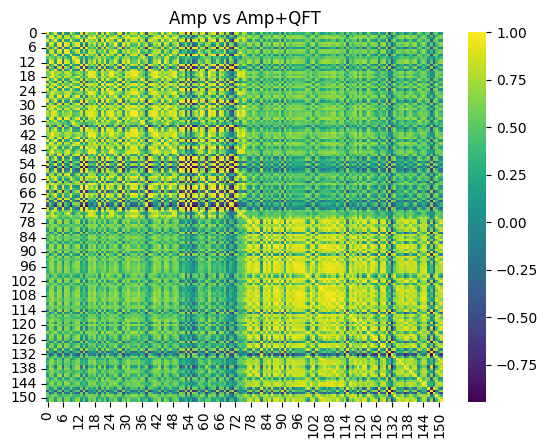

In [10]:
# QFT makes a difference for Amplitude Embedding
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp, quantum_fidelity_matrix_amp_qft), cmap='viridis')
plt.title('Amp vs Amp+QFT')

Text(0.5, 1.0, 'Angle vs Angle+QFT')

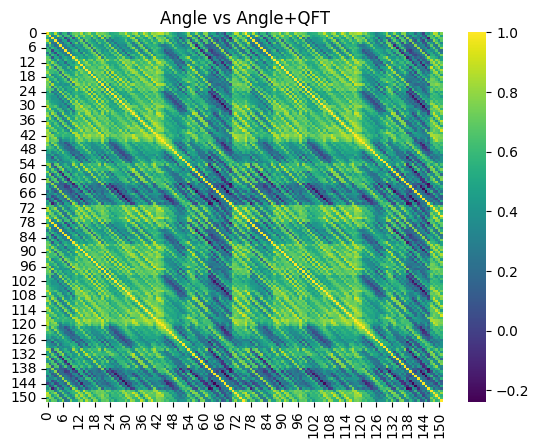

In [11]:
# Exactly the same for angle embedding
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_ang, quantum_fidelity_matrix_ang_qft), cmap='viridis')
plt.title('Angle vs Angle+QFT')

Text(0.5, 1.0, 'Amp vs Ang')

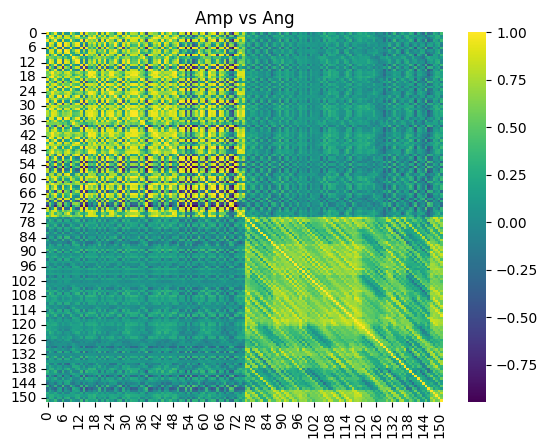

In [12]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp, quantum_fidelity_matrix_ang), cmap='viridis')
plt.title('Amp vs Ang')

Text(0.5, 1.0, 'Amp vs Ang QFT')

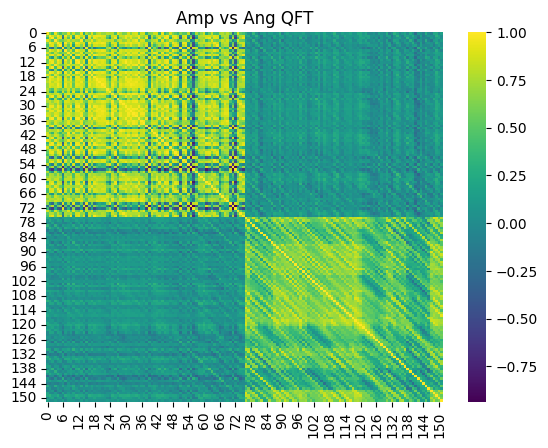

In [13]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp_qft, quantum_fidelity_matrix_ang), cmap='viridis')
plt.title('Amp vs Ang QFT')

Text(0.5, 1.0, 'Euclidean distance vs Euclidean distance after iFFT')

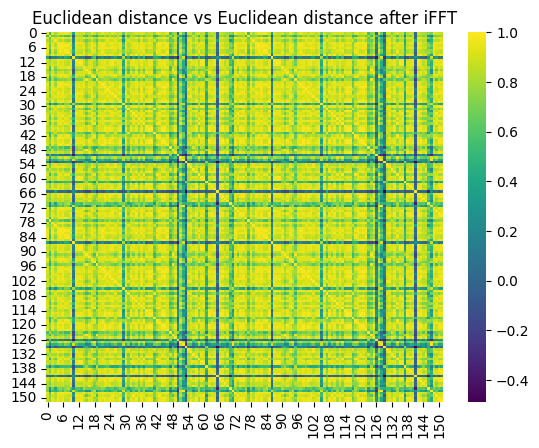

In [14]:
# exactly the same
sns.heatmap(np.corrcoef(euclidean_distance_df, euclidean_distance_ifft_df), cmap='viridis')
plt.title('Euclidean distance vs Euclidean distance after iFFT')

<Axes: >

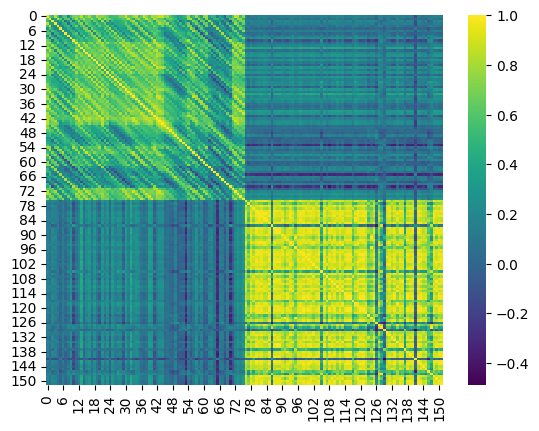

In [15]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_ang, euclidean_distance_df), cmap='viridis')

<Axes: >

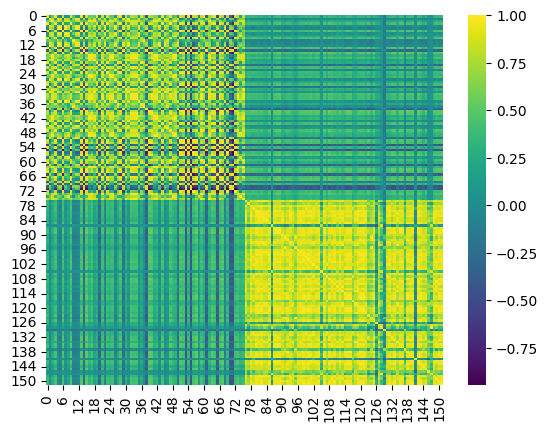

In [16]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp, euclidean_distance_df), cmap='viridis')

<Axes: >

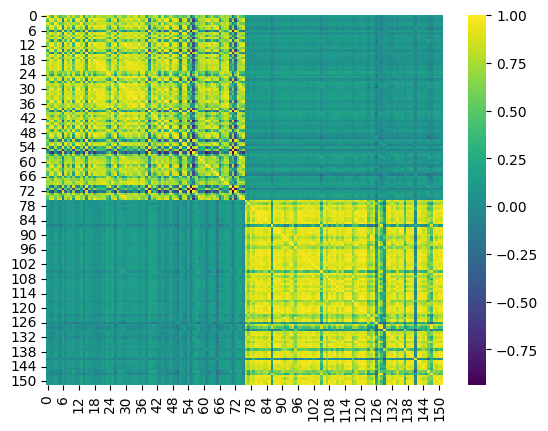

In [17]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp_qft, euclidean_distance_df), cmap='viridis')

# statistical testing
- the proper test for 2 distance matrices is actually Mantel's test.
- we can use this if we have *distance* matrices to measure the correlation (-1 to +1)
- https://fukamilab.github.io/BIO202/06-C-matrix-comparison.html
- says spearman method should be use when non-linearity is expected, which we use here
- as implemented in skbio, mantel's test requires the diagonals to be 0
- this means that we should invert state fidelity (1-fidelity) bc the middle diagonal is 1, not 0
- The diagonal for state fidelity is not exactly 0, but it's very close to 0 so we can use Mantel's test anyways

In [18]:
from skbio.stats.distance import mantel, pwmantel
# wrapping to fill diagonals to 0
def mantel_test(a, b):
    # a and b should be PD dataframes
    a_np = a.to_numpy() if type(a) is pd.DataFrame else a
    b_np = b.to_numpy() if type(b) is pd.DataFrame else b
    np.fill_diagonal(a_np, 0)  # in-place ops
    np.fill_diagonal(b_np, 0)
    return mantel(a_np, b_np, method='spearman', seed=0)

def pw_mantel_test(dfs, labels=None):
    # a and b should be PD dataframes
    dfs_np = [d.to_numpy() if type(d) is pd.DataFrame else d for d in dfs]
    for d in dfs_np:
        np.fill_diagonal(d, 0)
    return pwmantel(dfs_np, method='spearman', labels=labels, seed=0)

In [19]:
# not the same
pw_mantel_test(
    [
        quantum_fidelity_matrix_ang,
        quantum_fidelity_matrix_amp,
        quantum_fidelity_matrix_amp_qft,
        euclidean_distance_df
    ],
    labels=['Angle', 'Amp', 'Amp+QFT', 'Euclidean']
)
# rank correlation shows how correlated the ranks of data are

statistic  p-value   n    method  permutations alternative
dm1     dm2                                                                  
Angle   Amp         0.210883    0.002  76  spearman           999   two-sided
        Amp+QFT     0.281679    0.001  76  spearman           999   two-sided
        Euclidean   0.116311    0.151  76  spearman           999   two-sided
Amp     Amp+QFT     0.510871    0.001  76  spearman           999   two-sided
        Euclidean   0.257543    0.001  76  spearman           999   two-sided
Amp+QFT Euclidean   0.135725    0.097  76  spearman           999   two-sided

# percentiles of fidelity measures (ordinal rank)

Text(0, 0.5, 'Percentile')

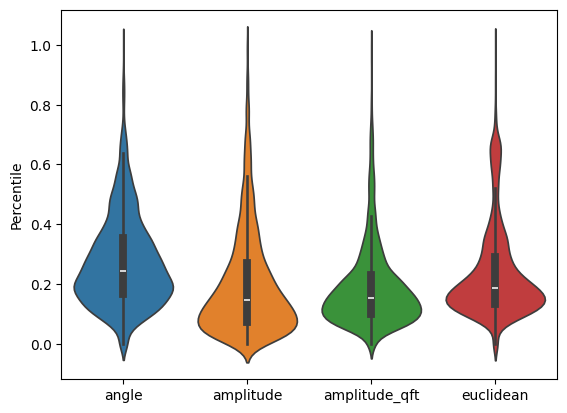

In [20]:
import seaborn as sns
sns.violinplot({
    'angle':         quantum_fidelity_matrix_ang.values.flatten() / quantum_fidelity_matrix_ang.values.max(),
    'amplitude':     quantum_fidelity_matrix_amp.values.flatten() / quantum_fidelity_matrix_amp.values.max(),
    'amplitude_qft': quantum_fidelity_matrix_amp_qft.values.flatten() / quantum_fidelity_matrix_amp_qft.values.max(),
    'euclidean':     euclidean_distance_df.values.flatten() / euclidean_distance_df.values.max()
})
plt.ylabel('Percentile')